In [1]:
from IPython.display import display, HTML
display(HTML ("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input{font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [2]:
import pandas as pd
import numpy as np
import sys # 최대 정수
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical # utils.to_categorical(): 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.models import Sequential #모델 생성
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # 데이터분리

## 이진분류(로지스틱 회귀분석)
- 1. 데이터셋 생성 & 전처리
    * 엑셀 -> 데이터프레임 -> ?처리(결측치로 전환하여 결측치처리) -> X, y분리
      -> X변수의 scale 조정 -> train_test_split() 이용하여 학습셋과 테스트셋분리
- 2. 모델생성(입력14, 출력1) & 학습과정 설정 & 학습
- 3. 모델평가(그래프, 평가, 혼동행렬==교차표)
- 4. 모델사용

In [ ]:
'''
age 나이 (세)
sex 성별
    1 : 남성
    0 : 여성
cp (chest pain type) 가슴 통증(흉통) 타입
    1 : typical angina (전형적 협심증)
    2 : atypical angina (비전형적 협심증)
    3 : non-anginal pain (심장 관련이 아닌 흉통)
    4 : asymptomatic (증상 없음)
treshtbps (resting blood pressure) 안정 시 수축기 혈압 (mm Hg)
    병원 처음 내원했을 때 잰 혈압이라고 보면 됨
chol (serum cholesterol) 혈청 콜레스테롤 수치 (mg/dl)
    여기 보니까 ?가 있어서, 일부 결측값이 문자로 들어가 있는 상태야
fbs (fasting blood sugar) 공복 혈당 > 120 mg/dl 여부
    1 : 공복 혈당 120 초과 (고혈당)
    0 : 아니면 0
restecg (resting electrocardiographic results) 안정시 심전도 결과
    0 : 정상
    1 : ST-T wave 이상 (ST-T 파 이상, T wave 반전 등)
    2 : LVH 가능성 (좌심실 비대 소견 등)
thalach (maximum heart rate achieved) 운동 검사에서 기록된 최대 심박수
exang (exercise induced angina) 운동으로 유발된 협심증 여부
    1 : 운동 시 흉통 있음
    0 : 없음
oldpeak 운동으로 인해 발생한 ST 절 하강 정도 (depression)
    숫자가 클수록 보통 심장 허혈 가능성↑로 봄
slope (slope of peak exercise ST segment) 운동 시 ST 세그먼트 기울기
    1 : upsloping (상승형)
    2 : flat (평평)
    3 : downsloping (하강형)
ca 조영제(조영술)에서 보이는 주요 관상동맥 수 (0~3)
    0이면 문제 있는 관상동맥이 없는 것, 
    숫자가 클수록 문제 있는 혈관 수가 많다고 보면 됨
    여기에도 ? 값 좀 섞여 있음
hsl (보통 다른 데이터셋에서는 thal) 아마 **thalassemia 관련 검사 결과(thal)**를 의미
    3 : normal
    6 : fixed defect (고정 결손)
    7 : reversible defect (가역 결손)
    여기도 숫자가 이런 패턴이라, 같은 의미로 봐도 될 듯
heartDisease (target) 심장질환 유무 (목표 변수)
'''

## 1. 데이터셋 생성 & 전처리
    * 엑셀 -> 데이터프레임 -> ?처리(결측치로 전환하여 결측치처리) -> X, y분리
      -> X변수의 scale 조정 -> train_test_split() 이용하여 학습셋과 테스트셋분리

In [5]:
# 아나콘다 프롬프트에서 ml-dl-nlp 가상환경(conda activate ml-dl-nlp)으로 간 후 pip install openpyxl
df = pd.read_excel('data/heart-disease.xlsx', sheet_name='processed.cleveland')
#df.info()
#df.isnull().sum()
df.isin(['?']).sum()

age             0
sex             0
cp              0
treshtbps       0
chol            1
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              4
hsl             2
heartDisease    0
dtype: int64

In [6]:
# '?'가 포함된 데이터 추출 (chol, ca, hsl)
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [7]:
# ?를 결측치(np.nan)로 대체 -> 결측치 대체(삭제)
df.replace('?', np.nan, inplace=True)
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease


In [8]:
# 결측치가 포함된 데이터 추출
df[df.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [9]:
# 결측치 처리: 대체(fillna), 삭제(dropna)
df = df.dropna(how='any') # 결측치가 한열이라도 있으면 삭제
df.isna().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [10]:
df.shape, len(df)

((296, 14), 296)

In [11]:
# target 변수의 분포가 균형을 이루는지
df['heartDisease'].value_counts() / df.shape[0]*100

0    54.054054
1    45.945946
Name: heartDisease, dtype: float64

In [12]:
# 입력(독립)변수와 타겟(종속, 출력)변수 분리
X = df.iloc[:, :-1].values # 맨 마지막열을 제외한 부분을 numpy 배열
y = df.iloc[:, -1:].values # 2차원 numpy 배열(train_test_split 사용)
X.shape, y.shape

((296, 13), (296, 1))

In [13]:
X[0]

array([ 63. ,   1. ,   1. , 145. , 233. ,   1. ,   2. , 150. ,   0. ,
         2.3,   3. ,   0. ,   6. ])

In [14]:
# 입력변수 X의 스케일 조정
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[0]

array([ 0.94228535,  0.69282032, -2.23679346,  0.74744089, -0.27722838,
        2.42563825,  1.02052624,  0.01445126, -0.69282032,  1.07483887,
        2.26408737, -0.71842092,  0.66026226])

In [15]:
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[0]

array([0.70833333, 1.        , 0.        , 0.48113208, 0.24429224,
       1.        , 1.        , 0.60305344, 0.        , 0.37096774,
       1.        , 0.        , 0.75      ])

In [16]:
# scaled_X, y를 학습셋: 테스트셋 = 7:3으로 분할
X_train, X_test, y_train, y_test = train_test_split(scaled_X,
                                                    y,
                                                    test_size=0.3, # 테스셋이 비율
                                                    random_state=7,
                                                    stratify=y) #층화추출

In [17]:
# 심장병 음성/양성의 비율
print(pd.DataFrame(y).value_counts(normalize=True))
print(pd.DataFrame(y_train).value_counts(normalize=True))
print(pd.DataFrame(y_test).value_counts(normalize=True))

0    0.540541
1    0.459459
dtype: float64
0    0.541063
1    0.458937
dtype: float64
0    0.539326
1    0.460674
dtype: float64


## 2. 모델생성(입력13, 출력1) & 학습과정 설정 & 학습
- 모델 : 13 -> 32 -> 16 -> 8 -> 1
- 그래프를 보고, 과적합 줄이기 추가할 수 있음

In [18]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Dense(units=32, input_dim=13, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
model.compile(loss='binary_crossentropy', 
              #optimizer=Adam(learning_rate = 0.01),
              optimizer='adam',
             metrics=['accuracy', # 정확도
                     Precision(), # 정밀도(예측값 중심)
                     Recall()]) # 재현율(실제값 중심)

In [20]:
hist = model.fit(X_train, y_train, # 훈련데이터셋
                epochs=200, #학습횟수
                validation_split=0.2, # 검증데이터를 훈련데이터의 20%로 사용
                verbose=1) # 간단 로그출력

Epoch 1/200
6/6 [==============================] - 1s 41ms/step - loss: 0.6999 - accuracy: 0.5394 - precision: 0.5132 - recall: 0.5000 - val_loss: 0.6880 - val_accuracy: 0.5476 - val_precision: 0.4583 - val_recall: 0.6471
Epoch 2/200
6/6 [==============================] - 0s 4ms/step - loss: 0.7169 - accuracy: 0.5515 - precision: 0.5250 - recall: 0.5385 - val_loss: 0.6818 - val_accuracy: 0.5000 - val_precision: 0.4091 - val_recall: 0.5294
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7104 - accuracy: 0.5273 - precision: 0.5000 - recall: 0.4872 - val_loss: 0.6752 - val_accuracy: 0.5476 - val_precision: 0.4583 - val_recall: 0.6471
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6877 - accuracy: 0.5636 - precision: 0.5469 - recall: 0.4487 - val_loss: 0.6694 - val_accuracy: 0.6190 - val_precision: 0.5200 - val_recall: 0.7647
Epoch 5/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.5576 - precision: 0.531

Epoch 38/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4673 - accuracy: 0.8545 - precision: 0.8649 - recall: 0.8205 - val_loss: 0.4692 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 39/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4623 - accuracy: 0.8424 - precision: 0.8611 - recall: 0.7949 - val_loss: 0.4653 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 40/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4804 - accuracy: 0.8121 - precision: 0.8219 - recall: 0.7692 - val_loss: 0.4620 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 41/200
6/6 [==============================] - 0s 5ms/step - loss: 0.4413 - accuracy: 0.8182 - precision: 0.7927 - recall: 0.8333 - val_loss: 0.4618 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 42/200
6/6 [==============================] - 0s 7ms/step - loss: 0.4834 - accuracy: 0.8121 - precision: 0

Epoch 75/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4054 - accuracy: 0.8545 - precision: 0.8750 - recall: 0.8077 - val_loss: 0.4353 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 76/200
6/6 [==============================] - 0s 7ms/step - loss: 0.4026 - accuracy: 0.8485 - precision: 0.8442 - recall: 0.8333 - val_loss: 0.4366 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 77/200
6/6 [==============================] - 0s 7ms/step - loss: 0.4450 - accuracy: 0.8182 - precision: 0.8333 - recall: 0.7692 - val_loss: 0.4366 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 78/200
6/6 [==============================] - 0s 7ms/step - loss: 0.4441 - accuracy: 0.8061 - precision: 0.7875 - recall: 0.8077 - val_loss: 0.4329 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 79/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3827 - accuracy: 0.8424 - precision: 0

Epoch 112/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3756 - accuracy: 0.8667 - precision: 0.8889 - recall: 0.8205 - val_loss: 0.4357 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 113/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3350 - accuracy: 0.8909 - precision: 0.8947 - recall: 0.8718 - val_loss: 0.4384 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 114/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4018 - accuracy: 0.8485 - precision: 0.8533 - recall: 0.8205 - val_loss: 0.4342 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 115/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3695 - accuracy: 0.8667 - precision: 0.9000 - recall: 0.8077 - val_loss: 0.4292 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 116/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4046 - accuracy: 0.8121 - precisi

Epoch 149/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3887 - accuracy: 0.8242 - precision: 0.8182 - recall: 0.8077 - val_loss: 0.4492 - val_accuracy: 0.8095 - val_precision: 0.7647 - val_recall: 0.7647
Epoch 150/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3672 - accuracy: 0.8424 - precision: 0.8611 - recall: 0.7949 - val_loss: 0.4345 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 151/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3963 - accuracy: 0.8182 - precision: 0.8429 - recall: 0.7564 - val_loss: 0.4279 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 152/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3298 - accuracy: 0.8727 - precision: 0.9254 - recall: 0.7949 - val_loss: 0.4268 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 153/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3541 - accuracy: 0.8788 - precisi

Epoch 186/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3328 - accuracy: 0.8848 - precision: 0.9403 - recall: 0.8077 - val_loss: 0.4724 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 187/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3637 - accuracy: 0.8485 - precision: 0.8732 - recall: 0.7949 - val_loss: 0.4756 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 188/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3380 - accuracy: 0.8606 - precision: 0.8767 - recall: 0.8205 - val_loss: 0.4800 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 189/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3140 - accuracy: 0.8788 - precision: 0.9028 - recall: 0.8333 - val_loss: 0.4772 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 190/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3813 - accuracy: 0.8424 - precisi

## 3. 모델평가(그래프, 평가, 교차표)

In [22]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

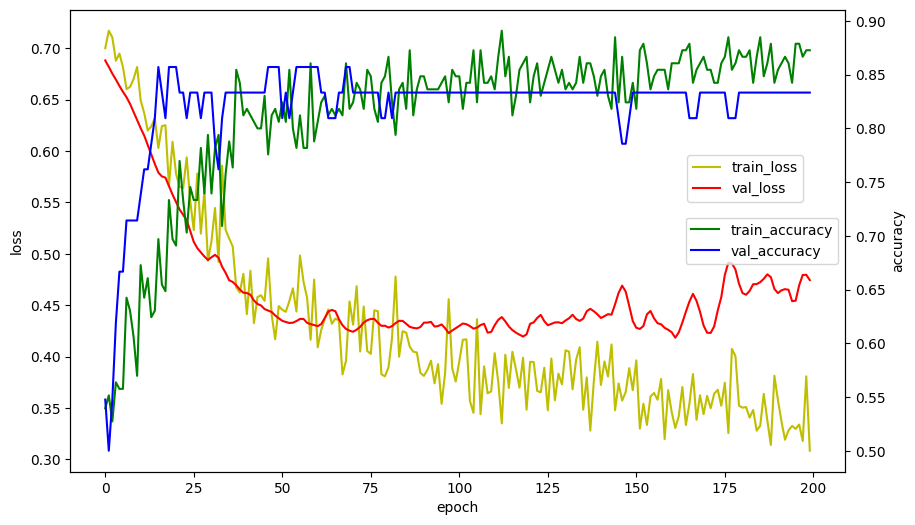

In [23]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print('model loss :', score[0])
print('model accuracy:', score[1])
print('model precision:', score[2])
print('model recall:', score[3])

model loss : 0.581421434879303
model accuracy: 0.7977527976036072
model precision: 0.7804877758026123
model recall: 0.7804877758026123


In [25]:
# 교차표(혼동행렬)
y_test.reshape(-1) # 실제값
y_hat = (model.predict(X_test)>0.5).astype(int).reshape(-1)
y_hat # 예측값

3/3 [==============================] - 0s 2ms/step


array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1])

In [26]:
TN=0; FP=0; FN=0; TP=0;
for y, h in zip(y_test, y_hat.reshape(-1)):
    #print(y, h)
    if y==0 and h==0:
        TN += 1 # TN갯수 하나 증가
    elif y==0 and h==1:
        FP += 1
    elif y==1 and h==0:
        FN += 1
    else:
        TP += 1
print(TN, FP)
print(FN, TP)

39 9
9 32


In [27]:
pd.crosstab(y_test.reshape(-1), #실제값
           y_hat.reshape(-1), #예측값
           rownames=['실제값'], # index이름
           colnames=['예측값']) # column이름 : 결과가 데이터 프레임인 교차표

예측값,0,1
실제값,,
0,39,9
1,9,32


In [28]:
confusion_matrix(y_test, y_hat)

array([[39,  9],
       [ 9, 32]], dtype=int64)

In [29]:
# 모델 사용
X_test[0]

array([0.58333333, 1.        , 1.        , 0.52830189, 0.34246575,
       0.        , 1.        , 0.3129771 , 1.        , 0.09677419,
       0.5       , 0.33333333, 0.75      ])

In [31]:
(model.predict([[0.5, 1, 1, 0.5, 0.3, 0, 1, 0.3, 1, 0.09, 0.5, 0.3, 0.75]])>0.5).astype(int)

1/1 [==============================] - 0s 35ms/step


array([[1]])

In [32]:
model.save('model/07.h5')
data = [[63, 1, 1, 145, 233, 1, 2, 150, 0, 2.3, 3, 0, 6]]
input_data  = scaler.transform(data)
(model.predict([input_data]) > 0.5).astype(int)

1/1 [==============================] - 0s 33ms/step


array([[0]])

# 분류분석
X_train, y_train, X_test, y_test

In [1]:
import pandas as pd
import numpy as np
import sys # 최대 정수
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical # utils.to_categorical(): 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.models import Sequential #모델 생성
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # 데이터분리

In [4]:
df = pd.read_excel('data/heart-disease.xlsx')
df.isin(['?']).sum()
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]
df.replace('?', np.nan, inplace=True)
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]
df[df.isna().any(axis=1)]
df = df.dropna(how='any')
dataset = df.values
dataset

array([[63.,  1.,  1., ...,  0.,  6.,  0.],
       [67.,  1.,  4., ...,  3.,  3.,  1.],
       [37.,  1.,  3., ...,  0.,  3.,  0.],
       ...,
       [68.,  1.,  4., ...,  2.,  7.,  1.],
       [57.,  1.,  4., ...,  1.,  7.,  1.],
       [57.,  0.,  2., ...,  1.,  3.,  1.]])

In [9]:
X_train = dataset[:100, :-1]
y_train = dataset[:100, -1]
X_val = dataset[100:200, :-1]
y_val = dataset[100:200, -1]
X_test = dataset[200:, :-1]
y_test = dataset[200:, -1]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((100, 13), (100,), (100, 13), (100,), (96, 13), (96,))

In [10]:
Y_train = utils.to_categorical(y_train)
Y_val   = utils.to_categorical(y_val, 2)
Y_test  = utils.to_categorical(y_test)
Y_train.shape, Y_val.shape, Y_test.shape

((100, 2), (100, 2), (96, 2))

In [12]:
print('원 데이터:', y_train[:3])
print('원핫인코딩 데이터:\n', Y_train[:3])

원 데이터: [0. 1. 0.]
원핫인코딩 데이터:
 [[1. 0.]
 [0. 1.]
 [1. 0.]]


In [37]:
model = Sequential()
model.add(Dense(units=32, input_shape=(None,13), activation='tanh'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, None, 32)          448       
                                                                 
 dense_21 (Dense)            (None, None, 16)          528       
                                                                 
 dense_22 (Dense)            (None, None, 2)           34        
                                                                 
Total params: 1,010
Trainable params: 1,010
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])

In [39]:
hist = model.fit(X_train, Y_train,
                epochs=200,
                validation_data=(X_val, Y_val),
                verbose=1)

Epoch 1/200
4/4 [==============================] - 1s 76ms/step - loss: 0.7710 - accuracy: 0.4400 - val_loss: 0.7015 - val_accuracy: 0.4900
Epoch 2/200
4/4 [==============================] - 0s 13ms/step - loss: 0.6937 - accuracy: 0.5100 - val_loss: 0.6718 - val_accuracy: 0.6300
Epoch 3/200
4/4 [==============================] - 0s 11ms/step - loss: 0.6584 - accuracy: 0.6400 - val_loss: 0.6697 - val_accuracy: 0.5700
Epoch 4/200
4/4 [==============================] - 0s 10ms/step - loss: 0.6571 - accuracy: 0.6000 - val_loss: 0.6825 - val_accuracy: 0.5500
Epoch 5/200
4/4 [==============================] - 0s 10ms/step - loss: 0.6581 - accuracy: 0.5800 - val_loss: 0.6810 - val_accuracy: 0.5300
Epoch 6/200
4/4 [==============================] - 0s 10ms/step - loss: 0.6510 - accuracy: 0.5900 - val_loss: 0.6780 - val_accuracy: 0.5800
Epoch 7/200
4/4 [==============================] - 0s 10ms/step - loss: 0.6449 - accuracy: 0.6800 - val_loss: 0.6744 - val_accuracy: 0.6000
Epoch 8/200
4/4 [===

Epoch 52/200
4/4 [==============================] - 0s 9ms/step - loss: 0.5857 - accuracy: 0.7300 - val_loss: 0.6164 - val_accuracy: 0.6500
Epoch 53/200
4/4 [==============================] - 0s 10ms/step - loss: 0.5776 - accuracy: 0.7300 - val_loss: 0.6325 - val_accuracy: 0.6400
Epoch 54/200
4/4 [==============================] - 0s 10ms/step - loss: 0.5635 - accuracy: 0.7200 - val_loss: 0.6490 - val_accuracy: 0.6100
Epoch 55/200
4/4 [==============================] - 0s 9ms/step - loss: 0.5552 - accuracy: 0.7400 - val_loss: 0.6538 - val_accuracy: 0.6200
Epoch 56/200
4/4 [==============================] - 0s 10ms/step - loss: 0.5525 - accuracy: 0.7400 - val_loss: 0.6465 - val_accuracy: 0.6400
Epoch 57/200
4/4 [==============================] - 0s 10ms/step - loss: 0.5577 - accuracy: 0.7500 - val_loss: 0.6425 - val_accuracy: 0.6500
Epoch 58/200
4/4 [==============================] - 0s 9ms/step - loss: 0.5650 - accuracy: 0.7300 - val_loss: 0.6454 - val_accuracy: 0.6500
Epoch 59/200
4/4

Epoch 168/200
4/4 [==============================] - 0s 10ms/step - loss: 0.4736 - accuracy: 0.8000 - val_loss: 0.6674 - val_accuracy: 0.6200
Epoch 169/200
4/4 [==============================] - 0s 9ms/step - loss: 0.4738 - accuracy: 0.7900 - val_loss: 0.6779 - val_accuracy: 0.6200
Epoch 170/200
4/4 [==============================] - 0s 11ms/step - loss: 0.4722 - accuracy: 0.7900 - val_loss: 0.6811 - val_accuracy: 0.6200
Epoch 171/200
4/4 [==============================] - 0s 11ms/step - loss: 0.4747 - accuracy: 0.7900 - val_loss: 0.6815 - val_accuracy: 0.6200
Epoch 172/200
4/4 [==============================] - 0s 11ms/step - loss: 0.4726 - accuracy: 0.7900 - val_loss: 0.6776 - val_accuracy: 0.6400
Epoch 173/200
4/4 [==============================] - 0s 10ms/step - loss: 0.4730 - accuracy: 0.7900 - val_loss: 0.6687 - val_accuracy: 0.6400
Epoch 174/200
4/4 [==============================] - 0s 9ms/step - loss: 0.4766 - accuracy: 0.8000 - val_loss: 0.6439 - val_accuracy: 0.6800
Epoch 17

In [40]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

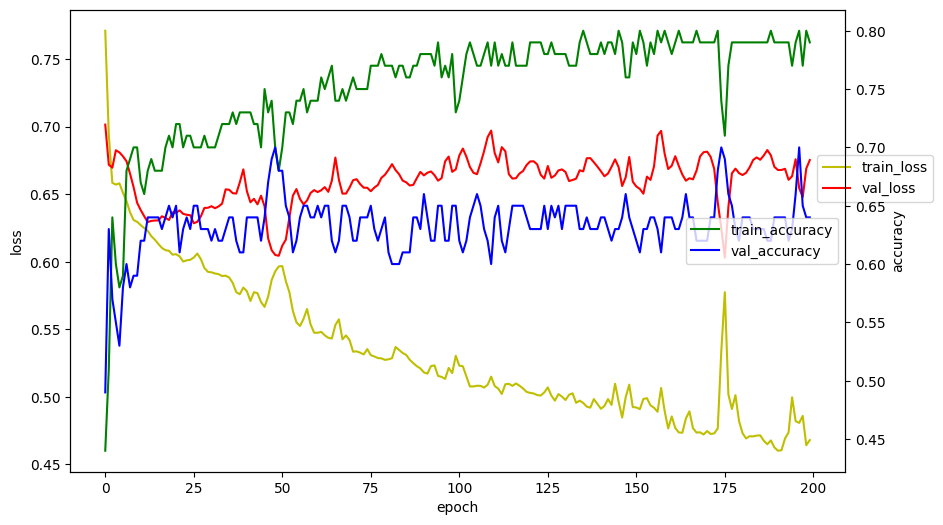

In [41]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [42]:
# 모델 평가
model.evaluate(X_test, Y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.7456 - accuracy: 0.6042


[0.745585024356842, 0.6041666865348816]

In [43]:
# 혼동행렬, 교차표
# y_test 실제값
y_hat = model.predict(X_test).argmax(axis=1)

3/3 [==============================] - 0s 2ms/step


In [44]:
pd.crosstab(y_test, y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0.0,40,9
1.0,29,18


In [33]:
# 강의
import pandas as pd
import numpy as np
import sys # 최대 정수
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical # utils.to_categorical(): 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.models import Sequential #모델 생성
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # 데이터분리

In [35]:
Y_train = to_categorical(y_train)
Y_test  = to_categorical(y_test)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((207, 13), (89, 13), (207, 2), (89, 2))

In [36]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Dense(units=32, input_dim=13, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                448       
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 2)                

In [37]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
model.compile(loss='categorical_crossentropy',
             # optimizer=Adam(learning_rate=0.01),
             optimizer='adam', 
             metrics=['accuracy', # 정확도
                     Precision(), # 정밀도(예측값 중심)
                     Recall()])   # 재현율(실제값 중심)

In [39]:
%%time
hist = model.fit(X_train, Y_train, # 훈련데이터셋
                epochs=200,            #  학습횟수
                validation_split=0.2,  # 검증데이터를 훈련데이터의 20%로 사용
                verbose=0) # 로그출력 안함

CPU times: total: 7.12 s
Wall time: 6.17 s


In [40]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

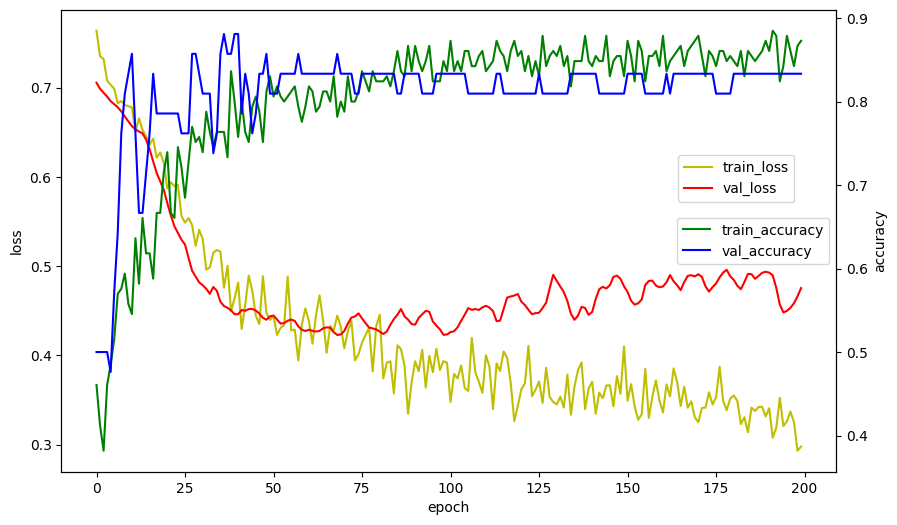

In [41]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [43]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('model loss :', score[0])
print('model accuracy :', score[1])
print('model precision :', score[2])
print('model recall :', score[3])

model loss : 0.5199826955795288
model accuracy : 0.7977527976036072
model precision : 0.7977527976036072
model recall : 0.7977527976036072


In [44]:
# 교차표(혼동행렬)
y_test.reshape(-1) # 실제값

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0], dtype=int64)

In [46]:
y_hat = model.predict(X_test).argmax(axis=1)
y_hat # 예측값

3/3 [==============================] - 0s 1ms/step


array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64)

In [47]:
pd.crosstab(y_test.reshape(-1), y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0,39,9
1,9,32


In [48]:
confusion_matrix(y_test, y_hat)

array([[39,  9],
       [ 9, 32]], dtype=int64)

In [49]:
data = [[63, 1, 1, 145, 233, 1, 2, 150, 0, 2.3, 3, 0, 6],
       [ 37, 1, 3, 130, 250, 0, 0, 187, 0, 3.5, 3, 0, 3]]
input_data  = scaler.transform(data)
model.predict([input_data], verbose=0).argmax(axis=1) # 둘다 심장병발병 음성 예측

array([0, 0], dtype=int64)